In [1]:
import warnings
warnings.filterwarnings('ignore')
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

%matplotlib inline

In [2]:
pd.set_option('display.max_columns', 500)
import matplotlib 

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['ytick.labelsize'] = 18
plt.rcParams['figure.figsize'] = 12, 6

In [3]:
# load the data
df = pd.read_csv('data/zillow_data.csv')

In [ ]:
df.head(5)

In [4]:
print(df[df['City']=='Chicago']['RegionName'].nunique())
print(df[df['State']=='DC']['RegionName'].nunique())
# print(df[df['Metro']=='Chicago']['RegionName'].nunique())

41
18


In [5]:
# get the DC data
dc_df = df[df['State']=='DC']
# drop unused columns
dc_df.drop(['RegionID','City','Metro','CountyName','SizeRank','State'],
           axis=1, inplace=True)
# get the list of zipcodes 
zipcodes = list(dc_df['RegionName'])
dc_df.drop(['RegionName'],axis=1,inplace=True)
# dc_df.head()

In [6]:
dc_df_T = dc_df.transpose(copy=True)
dc_df_T.reset_index()
# dc_time_stamp = pd.DataFrame()
dc_df_T['date'] = pd.to_datetime(dc_df_T.index)
dc_df_T.set_index('date', inplace=True)
dc_df_T.columns = zipcodes
dc_df_T.head()

,20002,20009,20011,20019,20001,20020,20008,20003,20032,20016,20010,20007,20024,20017,20018,20037,20015,20012
date,,,,,,,,,,,,,,,,,,
1996-04-01,94300.0,178800.0,118900.0,91300.0,92000.0,104500.0,450100.0,130000.0,85700.0,362000.0,110500.0,358100.0,209800.0,121700.0,123000.0,277800.0,312400.0,185000.0
1996-05-01,94000.0,179200.0,118500.0,91000.0,92600.0,103800.0,448200.0,130100.0,85500.0,361200.0,111200.0,356000.0,208200.0,121400.0,122400.0,275800.0,311000.0,184900.0
1996-06-01,93700.0,179600.0,118200.0,90600.0,93200.0,103000.0,446300.0,130200.0,85400.0,360300.0,112000.0,353900.0,206600.0,121200.0,121800.0,273700.0,309800.0,184700.0
1996-07-01,93600.0,180000.0,117800.0,90400.0,93900.0,102200.0,444500.0,130400.0,85200.0,359400.0,112900.0,351700.0,205000.0,121000.0,121200.0,271600.0,308700.0,184400.0
1996-08-01,93400.0,180300.0,117600.0,90100.0,94600.0,101400.0,442900.0,130600.0,85000.0,358500.0,113800.0,349600.0,203300.0,120900.0,120700.0,269500.0,307900.0,184100.0


In [ ]:
dc_df_T.info()

In [ ]:
# check for NA
dc_df_T.plot()

# Some functions

In [7]:
from statsmodels.tsa.stattools import adfuller
def ADF_Test(timeseries):
    """
    ADF_Test 
    print out parameters from the Dickey-Fuller test
    
    Parameters:
    timeseries 
    
    Returns:
    float p-value
    """
    #     print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dfoutput['p-value'] 
#     print(pvalue)
#     print(dfoutput)
    return pvalue

In [8]:
def Compare_Transformations(data, tdata):
    """ 
    Compare the data vs a trsnsformation of the  data
    drop null values, run an ADF test and return the p-value
    
    Input:
    time series: data, tdata 
    
    Return:
    Augmented Dickey Test p-value
    """
    tdiff = data - tdata
    tdiff.dropna(inplace=True)
    pvalue = ADF_Test(tdiff)

#     data.plot()
#     tdata.plot()
    return pvalue

In [9]:
def Plot_Compare(data, tdata):
    """
    Plot the difference between data and tdata
    To see if difference is stationary
    
    Input: 
    timeseries data and tdata
    Return:
    Matplotlib plt
    """
    y_diff = data - tdata
    y_diff.dropna(inplace=True)
    pval = Compare_Transformations(data,tdata)
    
    fig = plt.figure(figsize=(12,6))
    y_diff.plot()
    title = ' p-value: {0:1.2}'.format(pval)
    plt.title(title,fontsize=18)
    plt.xlabel('Date', fontsize=16)
    plt.ylabel(r'Delta data', fontsize=16)
    plt.grid(True)
    
    return plt

In [10]:
def Get_Best_Model(data, p_params, q_params):
    """
    Use a SARIMAX fit to get the best model for the data
    
    Input:
    timeseries: data
    list p and q parameter
    
    Return:
    Return the model with the lowest AIC
    """
    lowest_AIC =1e14
    best_param =0
    best_seasonal_param = 0
    p = range(0,np.max(p_params))
    d = range(0,2)
    q = range(0,np.max(q_params))
    p = p_params
    q = q_params
    pdq = list(itertools.product(p,d,q))
    seasonal_pdq = [(x[0], x[1],x[2],12) for x in list(itertools.product(p, d, q))]
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                
                mod = sm.tsa.statespace.SARIMAX(data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
                results = mod.fit()

                if results.aic < lowest_AIC:
                    lowest_AIC = results.aic
                    best_model = mod
                    best_param = param
                    best_seasonal_param = param_seasonal

            except:
                continue
            
    return best_model, best_param, best_seasonal_param

In [11]:
from statsmodels.tsa.stattools import pacf
def Get_q_params(data):
    """
    Get the q Parameters from an PACF 
    
    Return:
    list of the first 3 parameters
    """
    pcfarray, confintarray = pacf(data, alpha=.05)
    obs = len(data)
    q_params = []
    for i,v in enumerate(pcfarray):
        if (v <= (-1.96/np.sqrt(obs)) or v >= (1.96/np.sqrt(obs))):
            q_params.append(i)
    return q_params[:2]

In [12]:
from statsmodels.tsa.stattools import acf
def Get_p_params(data):
    """
    Get the p Parameters from an ACF 
    
    Return: 
    list of the first 3 p parameters
    """
    acfarray, confintarray = acf(data, alpha=.05)
    obs = len(data)
    p_params = []
    for i,v in enumerate(acfarray):
        if (v <= (-1.96/np.sqrt(obs)) or v >= (1.96/np.sqrt(obs))):
            p_params.append(i)
    return p_params[:2]

In [13]:

def Trend_elimination(data):
    """
    Apply different transformation on the data, calculate the p-value 
    from a ADF test, and return the data set with the lowest p-value
    
    Input:
    timeseries data
    
    Return:
    string name_of_transformation,  float p-value, timeseries transformed data 
    """
    data_transformed = []
    pvalues = []
    name = []
    
    # log data
#     print('Log data')
    name.append('Log_data')
    data_log = np.log(data)
    pvalue = Compare_Transformations(data, data_log)
    data_transformed.append(data_log)
    pvalues.append(pvalue)
    
    # sqrt
#     print('sqrt')
    name.append('sqrt_data')
    data_sqrt = np.sqrt(data)
    pvalue = Compare_Transformations(data, data_sqrt)
    data_transformed.append(data_sqrt)
    pvalues.append(pvalue)

#     print('diff 1')
    # diff
    name.append('diff_data')
    data_diff = data.diff()
    pvalue = Compare_Transformations(data, data_diff)
    data_transformed.append(data_diff)
    pvalues.append(pvalue)
    
#     print('rolling mean on data')
    # rolling mean
    name.append('rolling_mean_data')
    data_roll_mean = data.rolling(window=3).mean()
    pvalue = Compare_Transformations(data, data_roll_mean)
    data_transformed.append(data_roll_mean)
    pvalues.append(pvalue)
    
    # EWM
#     print('ewm on data')
    name.append('ewm_data')
    data_ewm = data.ewm(halflife= 2).mean()
    pvalue = Compare_Transformations(data, data_ewm)
    data_transformed.append(data_ewm)
    pvalues.append(pvalue)
    
    # on the log
    # rolling mean
#     print('rolling mean on log data')
    name.append('log_rolling_mean_data')
    data_log_roll_mean = data_log.rolling(window=3).mean()
    pvalue = Compare_Transformations(data, data_log_roll_mean)
    data_transformed.append(data_log_roll_mean)
    pvalues.append(pvalue)
    # EWM
    
#     print('EWM on log data')
    name.append('log_ewm_data')
    data_log_ewm = data_log.ewm(halflife= 2).mean()
    pvalue = Compare_Transformations(data, data_log_ewm)
    data_transformed.append(data_log_ewm)
    pvalues.append(pvalue)
    
#     print('EWM on rolling mean of log data')
    name.append('log_rollmean_ewm_data')
    data_log_roll_mean_ewm = data_log_roll_mean.ewm(halflife=2).mean()
    pvalue = Compare_Transformations(data, data_log_roll_mean_ewm)
    data_transformed.append(data_log_roll_mean_ewm)
    pvalues.append(pvalue)
    
    
    #compare all p-values and return the lowest one
    pvalue_min = np.min(pvalues)
#     print(pvalue_min)
    lowesti = pvalues.index(pvalue_min)
    return name[lowesti], pvalue_min, data_transformed[lowesti]

In [34]:
def Make_PredictionPlot(results, ytrain, ytest, zipcode,time_cut,print_test=True):
    fig = plt.figure(figsize=(14,7))
    pred = results.get_prediction(start=pd.to_datetime(time_cut)+pd.DateOffset(months=1),
                              end=pd.to_datetime('2019-04'),
                             dynamic=True)
    pred_ci = pred.conf_int() 
    
    ax = ytrain.plot(label='Train Data',lw=4)
    if print_test:
        ytest.plot(ax=ax, label='Test Data',lw=4, c='b')
    
    pred.predicted_mean.plot(ax = ax, label='Prediction',lw=4,
                             color='orange',linestyle='--')
    ax.fill_between(pred_ci.index,
               pred_ci.iloc[:,0],
               pred_ci.iloc[:,1], color='k', alpha=0.25)

#     pred_future = results.get_forecast(steps=16)
#     pred_ci2 = pred_future.conf_int()

#     pred_future.predicted_mean.plot(ax=ax, label=' Future Forecast')
#     ax.fill_between(pred_ci2.index, 
#                pred_ci2.iloc[:,0],
#                pred_ci2.iloc[:,1], color='k',alpha = 0.25)

    plt.title('Zipcode {}'.format(zipcode), fontsize=22)
    plt.xlabel('Date',fontsize=20)
    plt.ylabel('Price', fontsize=20)
    plt.legend(fontsize=18)
    plt.grid(True)

In [16]:
results = []
train_data = []
test_data =[]
pdq_params = []
seasonal_pdq_params = []
time_start = '2012'
time_cut = '2017-07'

for zipcode in zipcodes:
    
    y = dc_df_T[zipcode].resample('MS').mean()
    y_train = y[time_start:time_cut]

    y_test = y[time_cut:]
    y_test = y_test[1:]
    
    # make it stationary
    name, pvalue, ybest_data = Trend_elimination(y_train)    
    print("{0} The best data is the '{1}' data set, {2:1.2f}".format(zipcode, 
                                                                   name,
                                                                   pvalue
                                                                  ))
    
    # Get the Parameters on the difference between y and ybest
    y_diff = y_train - ybest_data
    y_diff.dropna(inplace=True)
    p_params = Get_p_params(y_diff)
    q_params = Get_q_params(y_diff)
    
    # Fit the MODEL
    model, best_order, best_seasonal_order = Get_Best_Model(y_train,
                                                        p_params,
                                                        q_params)
    
    result = model.fit()
    results.append(result)
    train_data.append(y_train)
    test_data.append(y_test)
    pdq_params.append(best_order)
    seasonal_pdq_params.append(best_seasonal_order)

20002 The best data is the 'rolling_mean_data' data set, 0.03


/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


20009 The best data is the 'rolling_mean_data' data set, 0.00


/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum 

20011 The best data is the 'ewm_data' data set, 0.09


/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum 

20019 The best data is the 'rolling_mean_data' data set, 0.75


/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum 

20001 The best data is the 'rolling_mean_data' data set, 0.03


/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum 

20020 The best data is the 'rolling_mean_data' data set, 0.10


/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum 

20008 The best data is the 'ewm_data' data set, 0.03


/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


20003 The best data is the 'rolling_mean_data' data set, 0.00


/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum 

20032 The best data is the 'rolling_mean_data' data set, 0.02


/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


20016 The best data is the 'rolling_mean_data' data set, 0.10


/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum 

20010 The best data is the 'rolling_mean_data' data set, 0.05


/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


20007 The best data is the 'rolling_mean_data' data set, 0.01


/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum 

20024 The best data is the 'ewm_data' data set, 0.00


/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum 

20017 The best data is the 'rolling_mean_data' data set, 0.23


/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum 

20018 The best data is the 'rolling_mean_data' data set, 0.19


/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


20037 The best data is the 'rolling_mean_data' data set, 0.02


/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


20015 The best data is the 'rolling_mean_data' data set, 0.17


/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


20012 The best data is the 'rolling_mean_data' data set, 0.02


/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum 

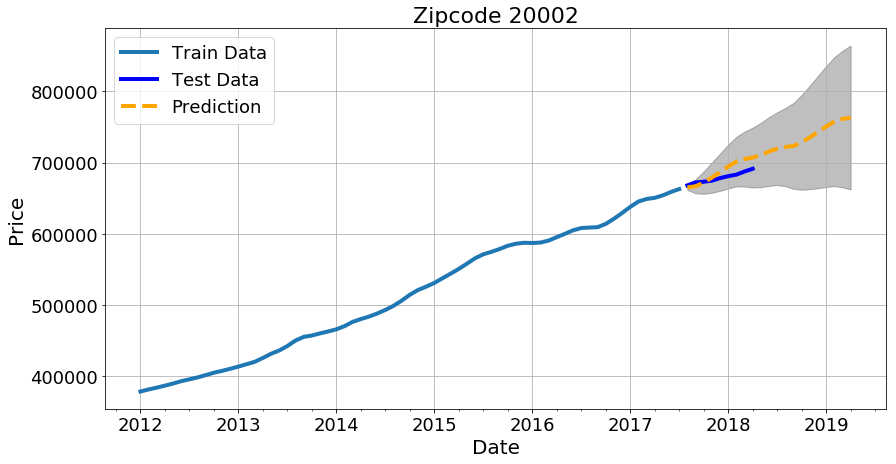

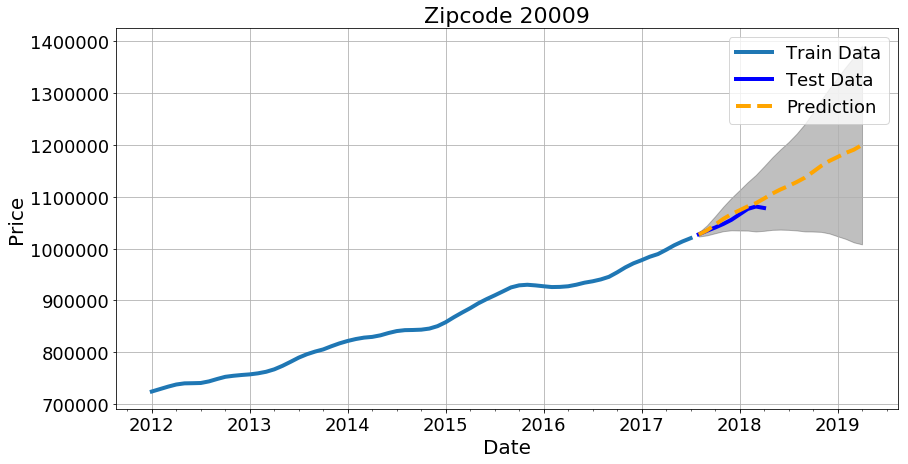

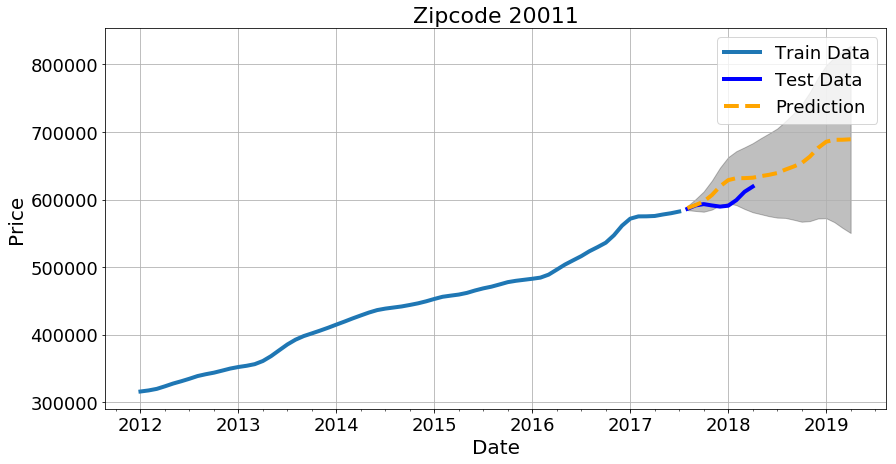

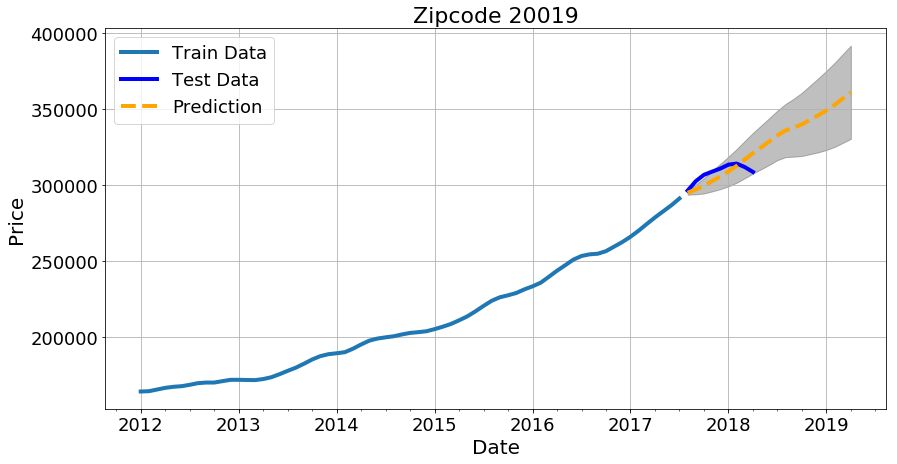

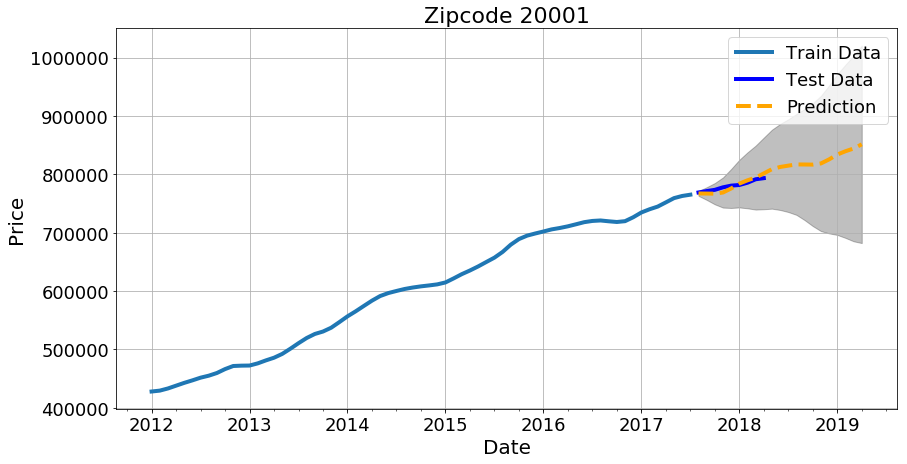

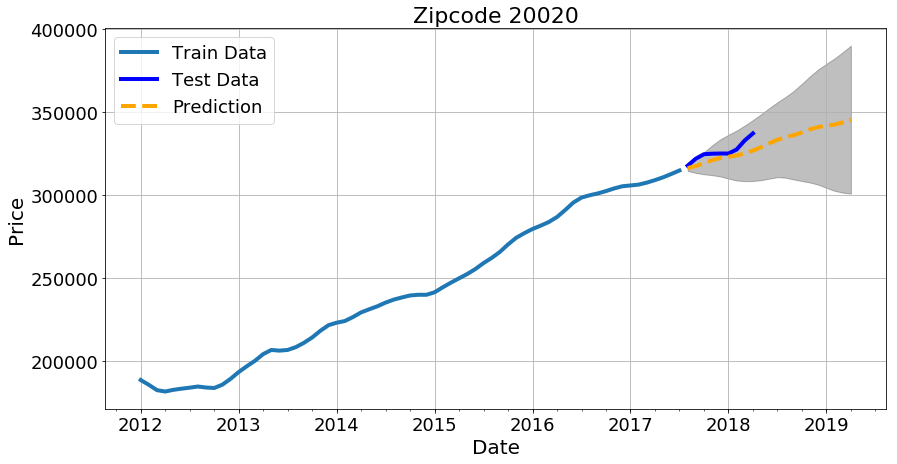

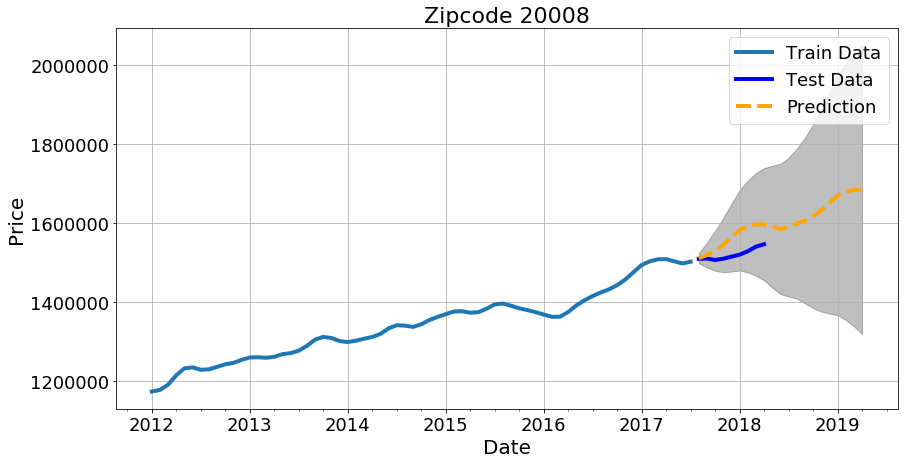

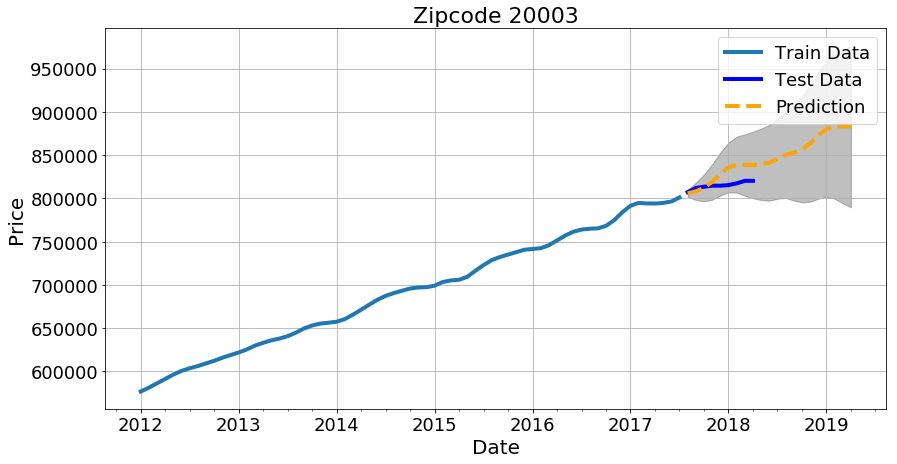

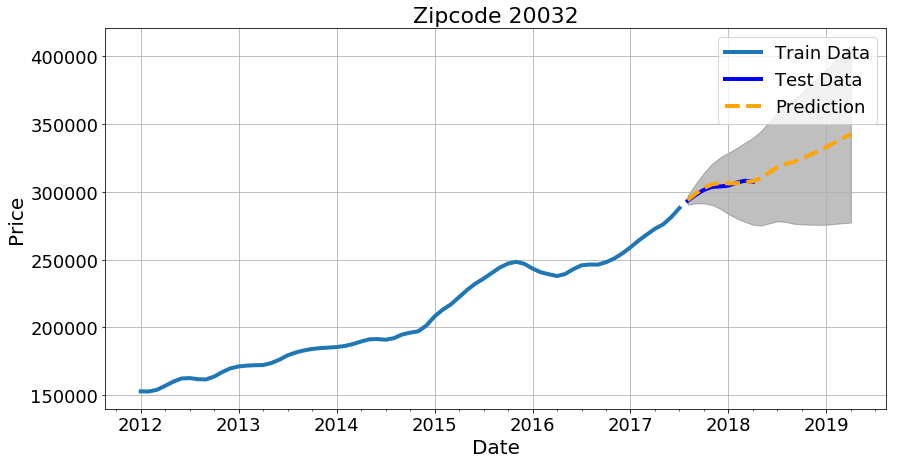

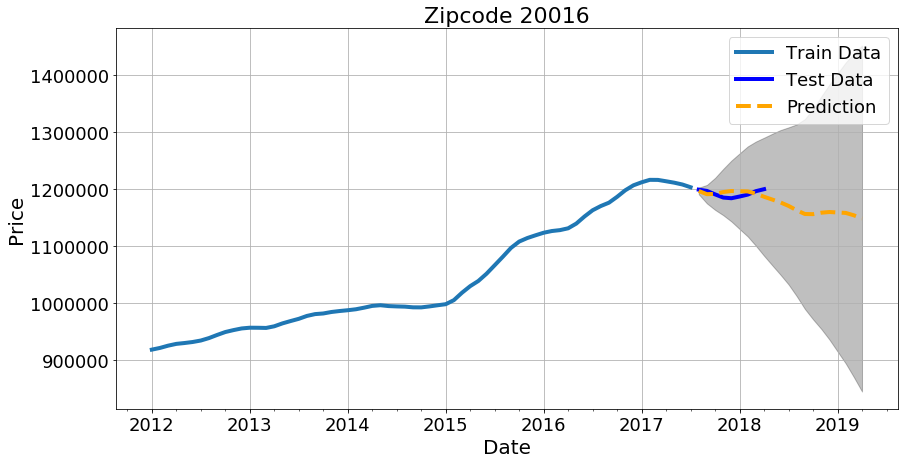

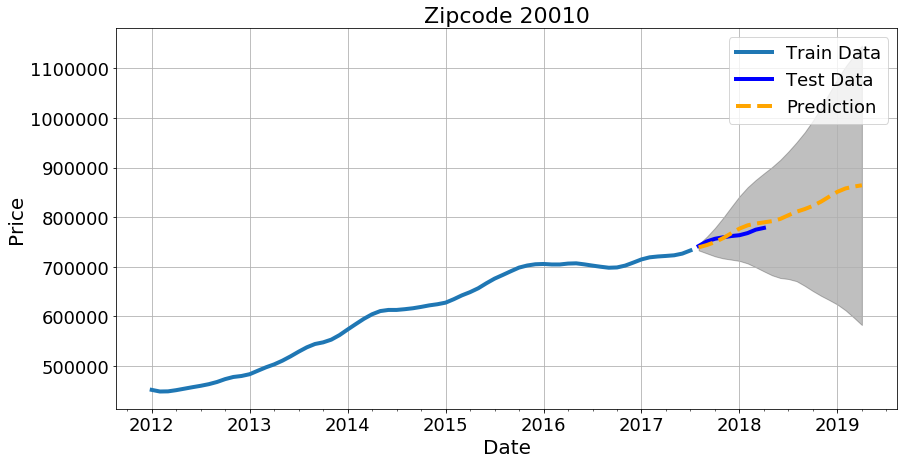

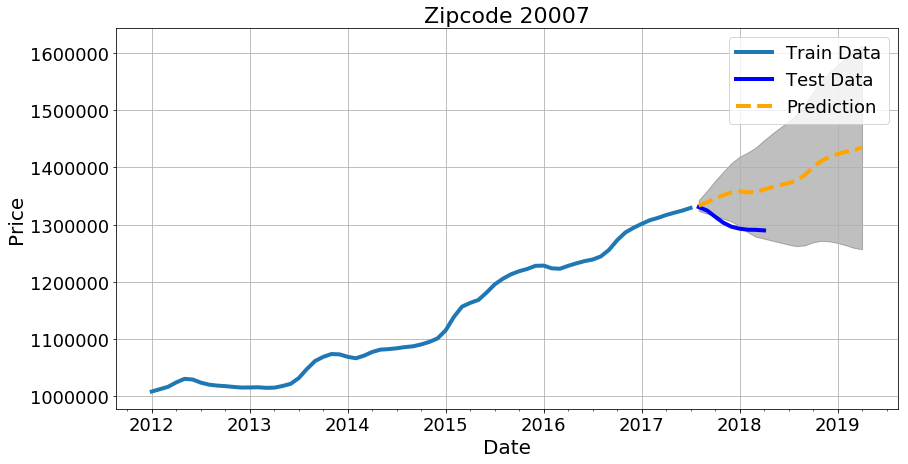

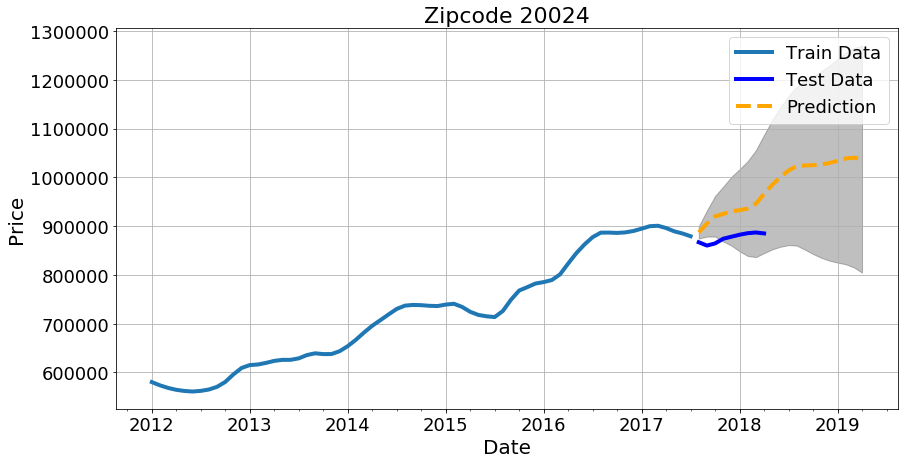

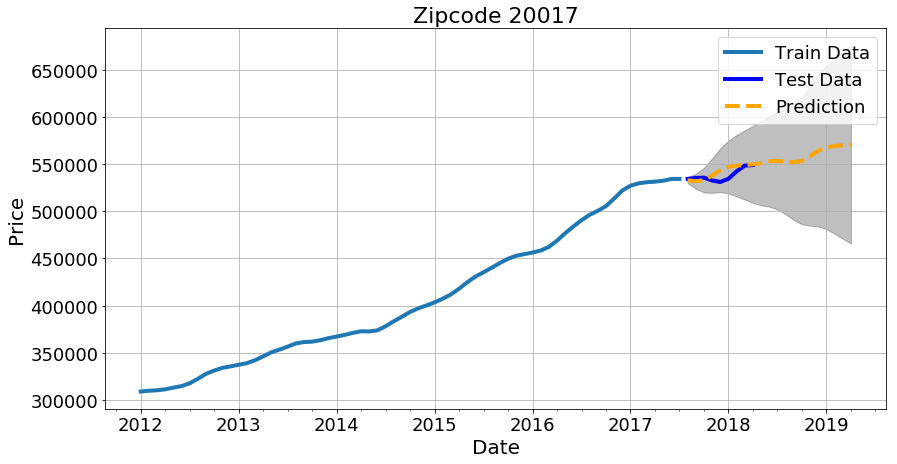

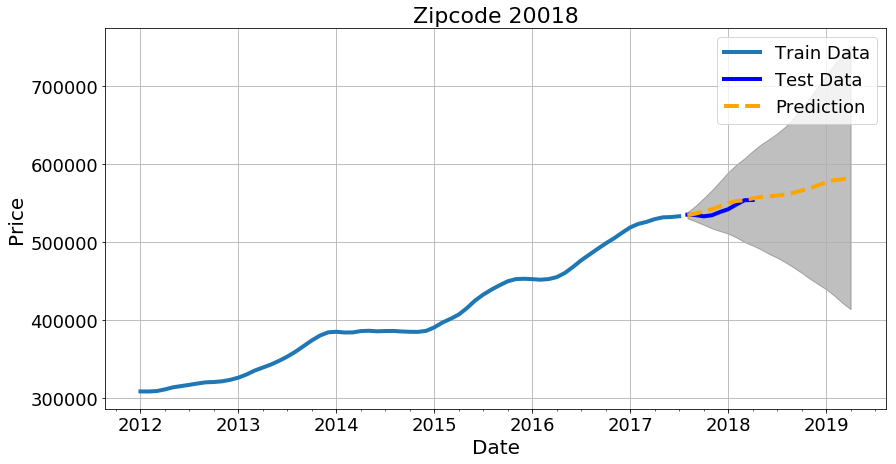

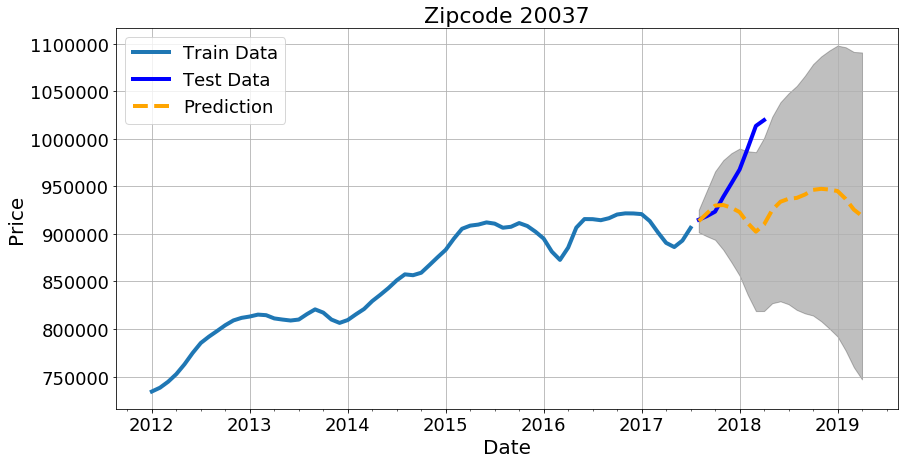

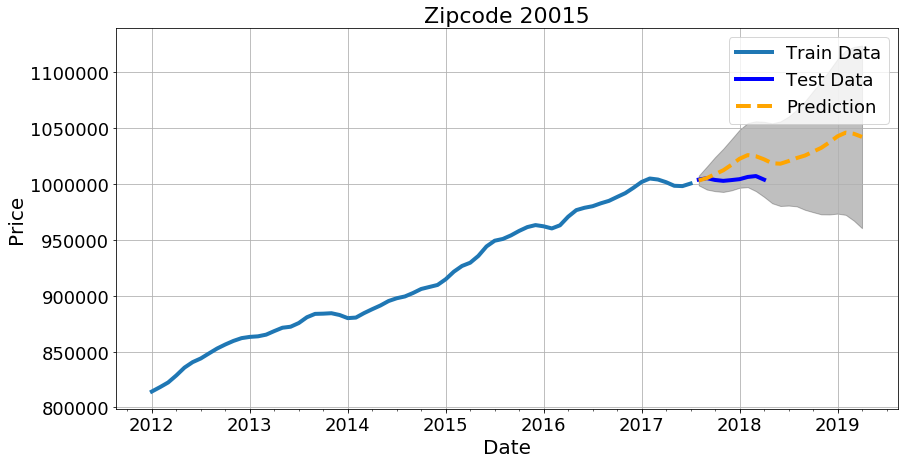

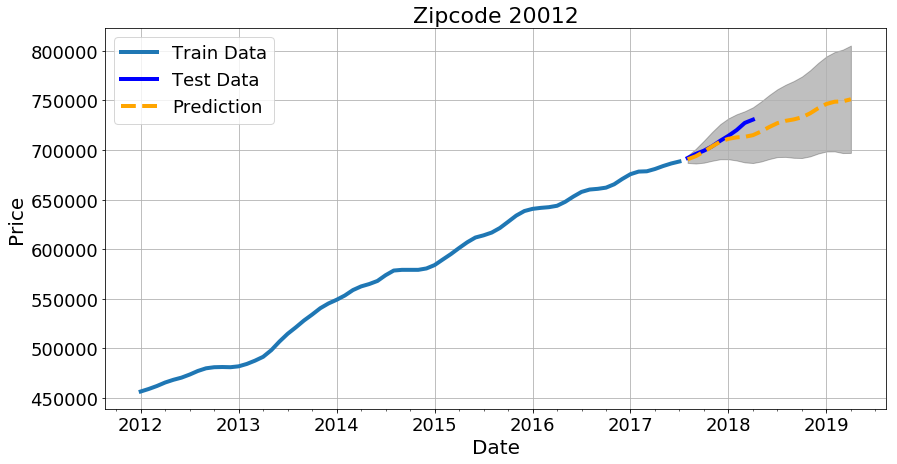

In [38]:
for i, val in enumerate(zipcodes):
    
    Make_PredictionPlot(results[i], train_data[i], 
                        test_data[i], val,time_cut,print_test=True)

In [18]:
import pickle
PIK = "zillow_fits.pkl"


with open(PIK, "wb") as f:
    for res in results:
#         print(res)
        pickle.dump(res, f)

In [19]:
# fileObject = open(PIK,'r')  
# load the object from the file into var b
# fit_results = pickle.load(fileObject)
fit_results = []
with open(PIK, "rb") as f:
    for i in range(4):
        fit_results.append(pickle.load(f))


In [20]:
fit_results

In [21]:
from sklearn import metrics

root_mean = []
r2 = []
for i,model in enumerate(results):
    pred = model.get_prediction(start=(pd.to_datetime(time_cut) + pd.DateOffset(months=1)),
                              end=pd.to_datetime('2018-04-01'),
                             dynamic=True)
    root_mean.append(np.sqrt(metrics.mean_squared_error(test_data[i], pred.predicted_mean)))
    r2.append(metrics.r2_score(test_data[i], pred.predicted_mean))
print(pred)
print(root_mean)
print(r2)

[11509.960453919126, 8842.53326368807, 21681.78062441835, 6228.461430572716, 5416.03858171228, 5343.166993657358, 44253.06464226623, 14023.379810529195, 1372.5937593397475, 8207.266966772033, 9636.693719128678, 52868.168312554444, 53708.90172627938, 6659.794727771913, 5255.684540792248, 60858.110456217044, 13608.035844260368, 7557.176991432006]
[-1.5659772837887869, 0.7820624555732332, -3.2605403926740992, -0.35133756866267274, 0.5542794617976047, 0.022858059963296706, -9.388943098327033, -12.329542339156655, 0.908995704047676, -1.0607867245459102, 0.1910134270064784, -11.81288206177228, -31.2090014716756, -0.09890437260670493, 0.5638409796564117, -1.5739558830875944, -103.49679394337936, 0.6617942618547001]


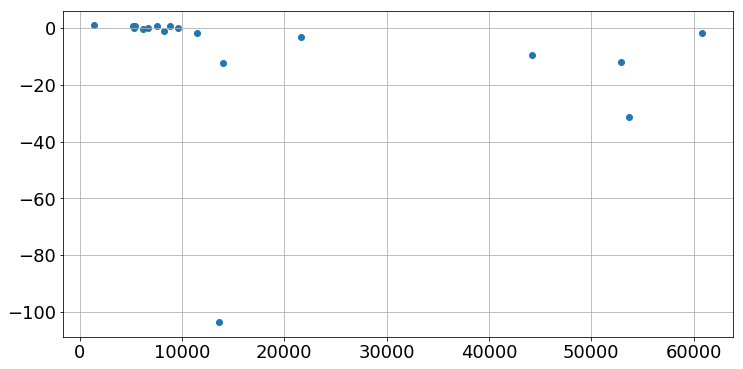

In [22]:
plt.scatter(root_mean, r2)
plt.grid(True)

In [23]:
best_zipcodes=[]
for i,model in enumerate(results):
    if(r2[i]>0 and root_mean[i]<10000):
        print(zipcodes[i])

20009
20001
20020
20032
20010
20018
20012


In [31]:
final_zipcodes = []
final_results = []
final_train_data = []
final_test_data =[]
final_pdq_params = []
final_seasonal_pdq_params = []
time_start = '2012'
time_cut = '2018-04' #last one


for i,model in enumerate(results):
    if(r2[i]>0 and root_mean[i]<10000):  

        zipcode = zipcodes[i]
        final_zipcodes.append(zipcode)
        y = dc_df_T[zipcode].resample('MS').mean()
        y_train = y[time_start:time_cut]

        y_test = y[time_cut:]
        y_test = y_test[1:]
    
 #   # make it stationary
##         name, pvalue, ybest_data = Trend_elimination(y_train) 

##         print("{0} The best data is the '{1}' data set, {2:1.2f}".format(zipcode, 
##                                                                    name,
##                                                                    pvalue
##                                                                   ))
    
    # Get the Parameters on the difference between y and ybest
##     y_diff = y_train - ybest_data
##     y_diff.dropna(inplace=True)
        p_params = pdq_params[i]
        q_params = seasonal_pdq_params[i]
    
        # Fit the MODEL with the best parameters
        print(q_params)
        model = sm.tsa.statespace.SARIMAX(y_train,
                                        order=p_params,
                                        seasonal_order=q_params,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
# #         model, best_order, best_seasonal_order = Get_Best_Model(y_train,
#                                                         p_params,
#                                                         q_params)
    
        result = model.fit()
        final_results.append(result)
        final_train_data.append(y_train)
        final_test_data.append(y_test)
        final_pdq_params.append(best_order)
        final_seasonal_pdq_params.append(best_seasonal_order)

(0, 1, 1, 12)
(0, 1, 1, 12)
(0, 1, 1, 12)
(1, 1, 1, 12)
(0, 1, 1, 12)
(1, 1, 1, 12)
(1, 1, 1, 12)


In [32]:
final_zipcodes

[20009, 20001, 20020, 20032, 20010, 20018, 20012]

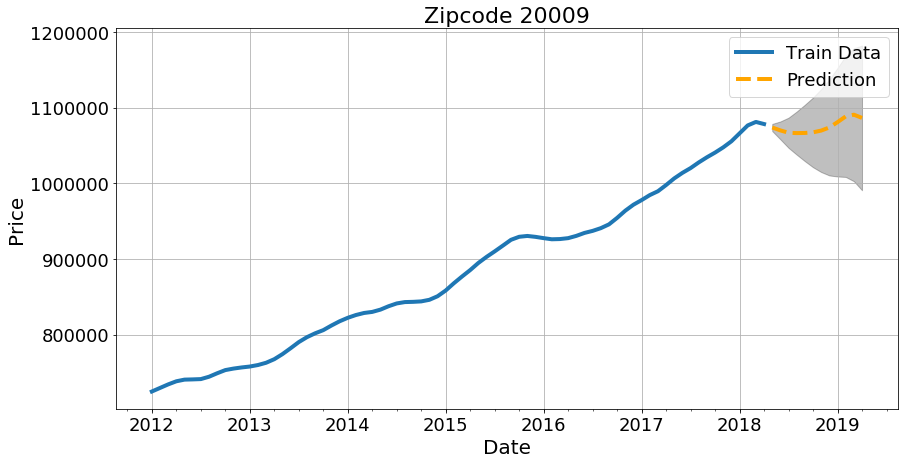

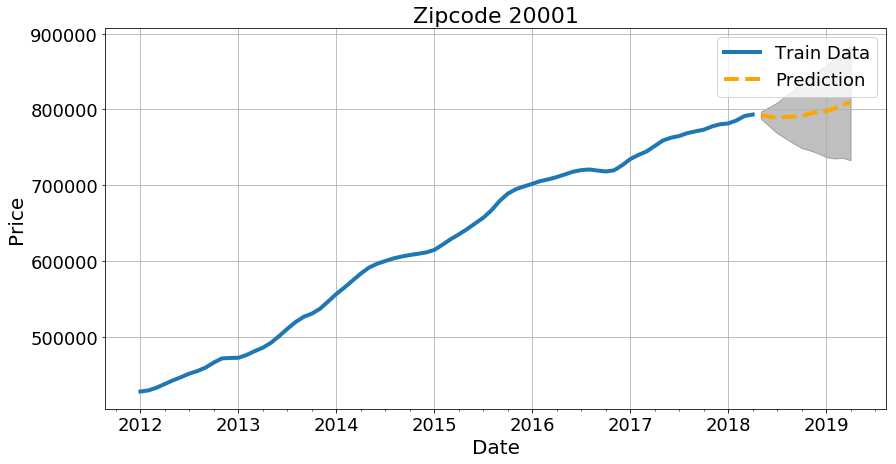

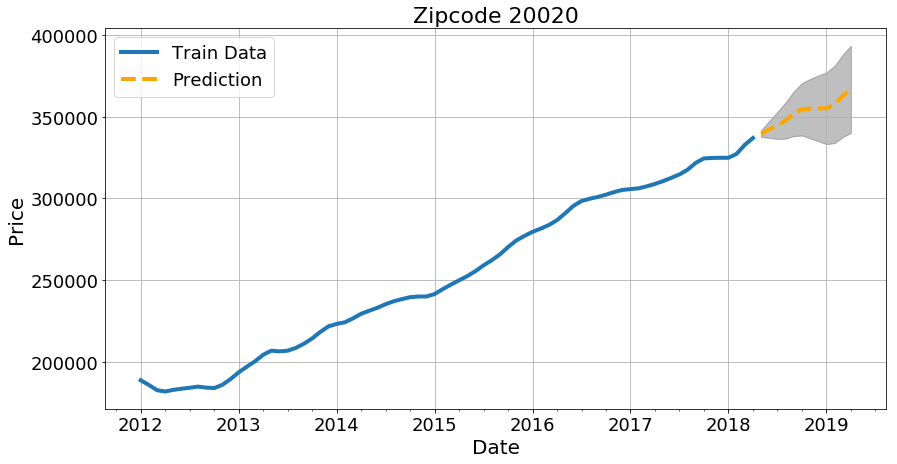

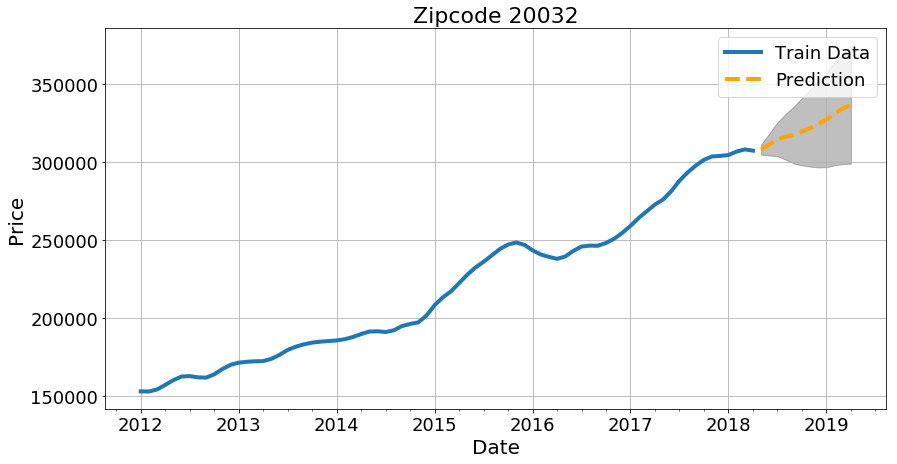

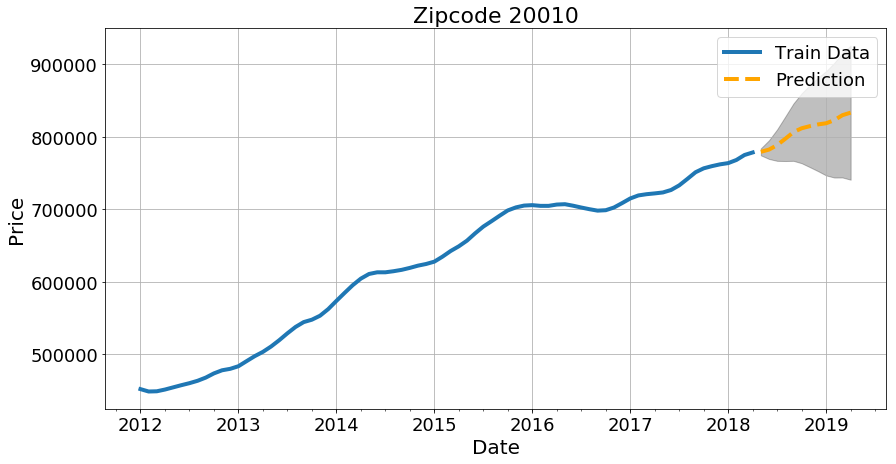

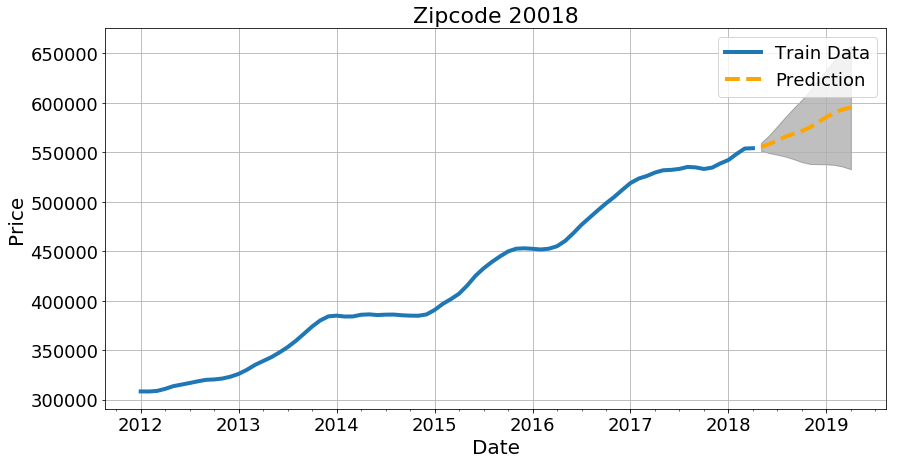

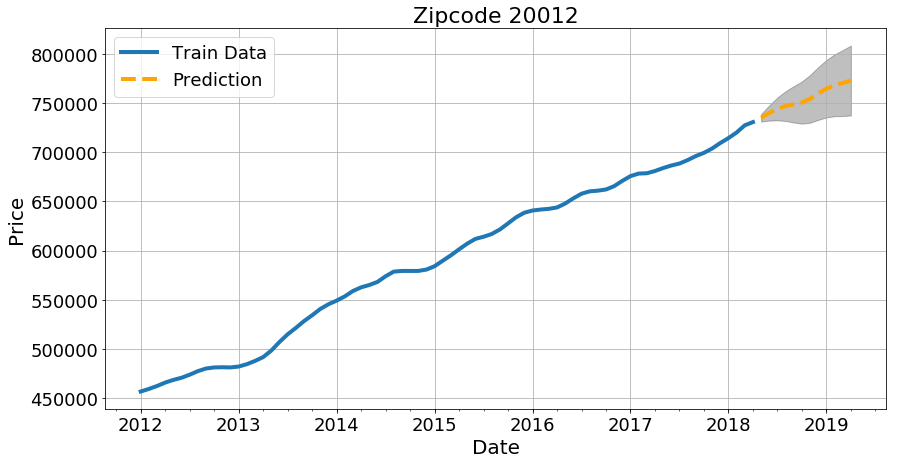

In [36]:
for i, val in enumerate(final_zipcodes):

    Make_PredictionPlot(final_results[i], final_train_data[i], 
                        final_test_data[i], val,time_cut, print_test=False)

In [40]:
profit = []
percent = []
for model in final_results:
    pred = model.get_prediction(start=pd.to_datetime('2018-04'),
                              end=pd.to_datetime('2019-04'),
                             dynamic=True)
    pred_ci = pred.conf_int()
    
    profit.append(pred.predicted_mean[-1] - pred.predicted_mean[0])
    percent.append(pred.predicted_mean[-1]/pred.predicted_mean[0]-1)
print(profit)
print(percent)

[80561.8514983682, 49703.516244382365, 34163.602370937995, 35852.92325280071, 77870.72966406355, 71712.23730961268, 49464.539000256336]
[0.07410334226346449, 0.062168816415515415, 0.10106972116354984, 0.11592004760379093, 0.09965608800503123, 0.12807074644756833, 0.067410991535503]


In [ ]:
     
    
                             color='orange',linestyle='--')
    ax.fill_between(pred_ci.index,
               pred_ci.iloc[:,0],
               pred_ci.iloc[:,1], color='k', alpha=0.25)

In [41]:
pred_ci

,lower 20012,upper 20012
2018-04-01,729932.538289,737618.609485
2018-05-01,732661.827065,748261.159812
2018-06-01,735229.043446,758503.909745
2018-07-01,736762.909712,767189.744722
2018-08-01,736918.054185,773921.119548
2018-09-01,736020.722297,779057.173645
2018-10-01,735331.000772,783918.099628
2018-11-01,736631.633922,790350.692702
2018-12-01,739814.640249,798306.042372
2019-01-01,742506.453582,805461.876473


In [ ]:
# 
results[0].plot_diagnostics(figsize=(12,8))